In [2]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from skorch import NeuralNetClassifier
import seaborn as sns
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt

Original model adapted to Checkbox data

In [2]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                                nn.Conv2d(1,8,3),
                                nn.ReLU(),
                                nn.Conv2d(8,64,3),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Dropout(0.5)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(3*3*64,256),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(256,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        print(out.size())
        out = out.view(-1,3*3*32)
        out = self.fcs(out)
        return out   

Checkbox classifier adapted to MNIST

In [3]:
class CheckBoxClassifier(torch.nn.Module):
    def __init__(self, n_output, drop_out):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1,
                                                                     out_channels=8,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True),
                                                     torch.nn.Conv2d(in_channels=8,
                                                                     out_channels=64,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True),
                                                     torch.nn.MaxPool2d(kernel_size=2),
                                                     torch.nn.Dropout(p=0.5))
                                                     
                                                    
                                                    
        
                                                     
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(p=0.5)

        self.classifier = torch.nn.Sequential(torch.nn.Linear(3*3*64,256),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(p=0.5),
                                              torch.nn.Linear(256,10),
                                              torch.nn.Softmax(dim=1))
        
    def forward(self,x):
        x = self.feature_extractor(x)
       # print(x.size())
        #x = self.max_pool(x)
        x = x.view(-1,3*3*64)
        x = self.flatten(x)
        
        x = self.classifier(x)
        return x 

    


In [4]:

mnist_train = MNIST('.', train=True, download=True, transform=ToTensor())
mnist_test  = MNIST('.', train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

In [5]:
X_train = X_train.reshape(60000, 1, 28, 28).numpy()
X_test = X_test.reshape(10000, 1, 28, 28).numpy()
y_train=y_train[:60000].numpy()
y_test= y_test[:10000].numpy()



In [6]:

initial_idx = np.array([],dtype=np.int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [7]:
batch_size = 8
num_workers = 0
shuffle = True
lr = 3e-4
epochs = 10
device = torch.device("cuda")
mean = [0.8372, 0.8372, 0.8375]
std = [0.2755, 0.2757, 0.2748]
drop_out = 0.3
n_output = 3
size = (64,64)

In [8]:
model = CheckBoxClassifier(n_output=n_output, drop_out= drop_out)
#model=CNN()
model

CheckBoxClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout1): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [9]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [10]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    
    perf_hist = [learner.score(X_test, y_test)]
    times_per_iteration = []
    
    for index in range(n_queries):
        torch.cuda.synchronize()  # wait for move to complete
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        #Acquired_samples.append(query_instance)
        #print(len(X_pool),len(y_pool))
        #model_loss=learner.score(X_initial, y_initial)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
        #loss.append(model_loss)
        torch.cuda.synchronize()  # wait for all_reduce to complete
        end.record()
        torch.cuda.synchronize()  # need to wait once more for op to finish
        times_per_iteration.append(start.elapsed_time(end))
    return perf_hist,times_per_iteration,learner


In [11]:
def baldnew(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=1000, replace=False)
    All_preds = np.zeros(shape=(random_subset.shape[0], 10))
    All_Entropy_Dropout = np.zeros(shape=random_subset.shape[0])
    with torch.no_grad():
        for t in range(100):
            preds = learner.estimator.forward(X[random_subset], training=True).cpu().numpy()
            All_preds = All_preds + preds
            epsilon = np.finfo(np.float).eps 
            Entropy_per_dropout = -(np.multiply(preds,np.log(preds + 1e-10))).sum(axis=1)
            #print(Entropy_per_dropout)
            #outputs_log = np.log2(outputs+ 1e-10)
            #Entropy_Compute = - np.multiply(outputs, outputs_log)
            #Entropy_Per_Dropout = np.sum(Entropy_Compute, axis=1)

            All_Entropy_Dropout = All_Entropy_Dropout + Entropy_per_dropout 
            
   
    #print(All_Entropy_Dropout)
    Avg_Pred = np.divide(All_preds,100)     #average over 100 forward passes
    epsilon = np.finfo(np.float).eps 
    Entropy_Average = - (np.multiply(Avg_Pred,np.log(Avg_Pred + 1e-10))).sum(axis=1)
    #G_X = Entropy_Average

    Exp_Entropy = np.divide(All_Entropy_Dropout,100)

    #F_X = Exp_Entropy

    Gain = Entropy_Average - Exp_Entropy
    
    a_1d = Gain.flatten()
    idx = a_1d.argsort()[-n_instances:][::-1]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=50,
                                batch_size=8,
                                lr=3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
bald_perf_hist,times_per_iteration,modified_learner  = active_learning_procedure(baldnew,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.3656
Accuracy after query 2: 0.5000
Accuracy after query 3: 0.5868
Accuracy after query 4: 0.6447
Accuracy after query 5: 0.7124
Accuracy after query 6: 0.7507
Accuracy after query 7: 0.7526
Accuracy after query 8: 0.7679
Accuracy after query 9: 0.7777
Accuracy after query 10: 0.7915
Accuracy after query 11: 0.8067
Accuracy after query 12: 0.8338
Accuracy after query 13: 0.8352
Accuracy after query 14: 0.8557
Accuracy after query 15: 0.8730
Accuracy after query 16: 0.8778
Accuracy after query 17: 0.8846
Accuracy after query 18: 0.8913
Accuracy after query 19: 0.8810
Accuracy after query 20: 0.8820
Accuracy after query 21: 0.8918
Accuracy after query 22: 0.8973
Accuracy after query 23: 0.9016
Accuracy after query 24: 0.9018
Accuracy after query 25: 0.8999
Accuracy after query 26: 0.9083
Accuracy after query 27: 0.9014
Accuracy after query 28: 0.9058
Accuracy after query 29: 0.9088
Accuracy after query 30: 0.9153
Accuracy after query 31: 0.9176
Accuracy after qu

In [12]:
from scipy.stats import mode
def var_ratio(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=1000, replace=False)
    All_Dropout_Classes = np.zeros(shape=(random_subset.shape[0],1))
    
    with torch.no_grad():
        for t in range(100):
            probs = learner.estimator.forward(X[random_subset], training=True)
            _, predicted = torch.max(probs.data, 1) #get class label
            predicted=predicted.numpy()
            dropout_classes = np.array([predicted]).T
            All_Dropout_Classes = np.append(All_Dropout_Classes, dropout_classes, axis=1)# append class labels based on iteration columnwise
            
        Variation = np.zeros(shape=(random_subset.shape[0]))

        for t in range(random_subset.shape[0]): #samples
            L = np.array([0])
            for d_iter in range(100): # no of dropouts
                L = np.append(L, All_Dropout_Classes[t, d_iter+1]) # class labels for a sample in a row
                
            Predicted_Class, Mode = mode(L[1:]) # calculate the mode
            #print(Predicted_Class, Mode)
            v = np.array(  [1 - Mode/float(100)])# variation=(1-mode/dropout iterations)
            Variation[t] = v
            

        a_1d = Variation.flatten()
        idx = a_1d.argsort()[-n_instances:][::-1]# samples with high variation ratio
        query_idx = random_subset[idx]
    return query_idx, X[query_idx]
        

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=50,
                                batch_size=8,
                                lr=3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
var_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(var_ratio,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [13]:
import pickle
filename="baldcheckboxmnist3.sav"
pickle.dump(modified_learner,open(filename,'wb'))

C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CheckBoxClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Max Accuracy : 0.9629
Total time taken (in Mins) =  44.37


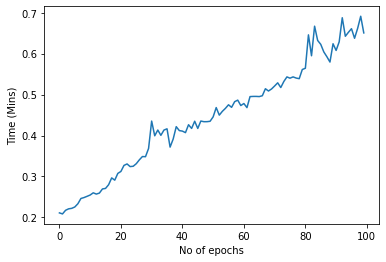

In [20]:

print("Max Accuracy :",max(bald_perf_hist))
%matplotlib inline

times_per_iteration1=[]
times_per_iteration1[:] = [x / 100000 for x in times_per_iteration]

plt.plot(range(0,100),times_per_iteration1)
plt.xlabel("No of epochs")
plt.ylabel("Time (Mins)")
print("Total time taken (in Mins) = ",round(sum(times_per_iteration1),2))

In [15]:
np.save('timetaken_baldcheckboxmnist3.npy',times_per_iteration1)
np.save('Accuracy_baldcheckboxmnist3.npy',bald_perf_hist)

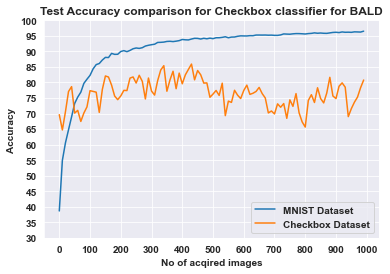

In [6]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

a5=np.load('./MNIST_performance/BALD/Average_baldcheckboxmnist.npy')
a6= np.load('./BALD1/Checkbox/Average_baldcheckbox.npy')

x= np.arange(0,1000,10)
y= a5[1:101]
w=np.arange(0,1000,10)
v= a6[1:101]
plt.plot(x,y*100,label="MNIST Dataset")
plt.plot(w,v*100,label="Checkbox Dataset")

plt.xlabel('No of acqired images')
plt.ylabel('Accuracy')
plt.ylim(30, 1*100)
#plt.xlim(xmin*100,xmax*100)
plt.xticks(np.arange(0,1001, 100))

plt.yticks(np.arange(30,101, 5))
plt.title("Test Accuracy comparison for Checkbox classifier for BALD",fontweight="bold")
plt.legend()

In [5]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

a5=np.load('./MNIST_performance/VarRatio/Average_varratiocheckboxmnist.npy')
a6= np.load('./VarRatio/Checkbox/Average_varratiocheckbox.npy')

x= np.arange(0,1000,10)
y= a5[1:101]
w=np.arange(0,1000,10)
v= a6[1:101]
plt.plot(x,y*100,label="MNIST Dataset")
plt.plot(w,v*100,label="Checkbox Dataset")

plt.xlabel('No of acqired images')
plt.ylabel('Accuracy')
plt.ylim(30, 1*100)
#plt.xlim(xmin*100,xmax*100)
plt.xticks(np.arange(0,1001, 100))

plt.yticks(np.arange(30,101, 5))
plt.title("Test Accuracy comparison for Checkbox classifier for Variation Ratio",fontweight="bold")
plt.legend()